<a href="https://colab.research.google.com/github/arshika77/snns_and_sdm_code_implementation/blob/master/SNN_using_BindsNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All statements in this notebook are quoted from the official BindsNet documentation

In [1]:
!pip install git+https://github.com/BindsNET/bindsnet.git

  Cloning https://github.com/BindsNET/bindsnet.git to /tmp/pip-req-build-tg8l0vuy
  Running command git clone -q https://github.com/BindsNET/bindsnet.git /tmp/pip-req-build-tg8l0vuy
     |████████████████████████████████| 317kB 4.4MB/s 
     |████████████████████████████████| 81kB 5.1MB/s 
  Created wheel for BindsNET: filename=BindsNET-0.2.7-cp36-none-any.whl size=95638 sha256=610ac0a7272df7df7325d1eff08610a850dfe5909db97d69635065a79990dd21
  Stored in directory: /tmp/pip-ephem-wheel-cache-lwilu8ii/wheels/45/a2/fb/ec4c62d26f48339c0d2d77a112ea5725ebf56c046715f8c6df
Successfully built BindsNET


In [2]:
from bindsnet.network import Network

network = Network()

In [3]:
from bindsnet.network.nodes import LIFNodes

# Create a layer of 100 LIF neurons with shape (10, 10).
layer = LIFNodes(n=100, shape=(10, 10))

In [4]:
network.add_layer(
    layer=layer, name="LIF population"
)

Such layers are kept in the dictionary attribute network.layers, and can be accessed by the user; e.g., by network.layers['LIF population'].

Other layer types include bindsnet.network.nodes.Input (for user-specified input spikes), bindsnet.network.nodes.McCullochPitts (the McCulloch-Pitts neuron model), bindsnet.network.nodes.AdaptiveLIFNodes (LIF neurons with adaptive thresholds), and bindsnet.network.nodes.IzhikevichNodes (the Izhikevich neuron model). Any number of layers can be added to the network.

Custom nodes objects can be implemented by sub-classing bindsnet.network.nodes.Nodes, an abstract class with common logic for neuron simulation. The functions forward(self, x: torch.Tensor) (computes effects of input data on neuron population; e.g., voltage changes, spike occurrences, etc.), reset_state_variables(self) (resets neuron state variables to default values), and _compute_decays(self) must be implemented, as they are included as abstract functions of bindsnet.network.nodes.Nodes.

In [5]:
from bindsnet.network.nodes import Input
from bindsnet.network.topology import Connection

# Create two populations of neurons, one to act as the "source"
# population, and the other, the "target population".
source_layer = Input(n=100)
target_layer = LIFNodes(n=1000)

# Creates an all-to-all connection between the two layers.
connection = Connection(
    source=source_layer, target=target_layer
)

In [8]:
network.add_layer(
    layer=source_layer, name="A"
)
network.add_layer(
    layer=target_layer, name="B"
)
network.add_connection(
    connection=connection, source="A", target="B"
)

Connections are kept in the dictionary attribute network.connections, and can be accessed by the user; e.g., by network.connections['A', 'B']. The layers must be added to the network with matching names (respectively, A and B) in order for the connection to work properly. There are no restrictions on the directionality of connections; layer “A” may connect to layer “B”, and “B” back to “A”, or “A” may connect directly back to itself.

bindsnet.network.monitors.AbstractMonitor objects can be used to record tensor-valued variables over the course of simulation in certain network components. To create a monitor to monitor a single component:

In [9]:
from bindsnet.network.monitors import Monitor

network = Network()

source_layer = Input(n=100)
target_layer = LIFNodes(n=1000)

connection = Connection(
    source=source_layer, target=target_layer
)

# Create a monitor.
monitor = Monitor(
    obj=target_layer,
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=500,  # Length of simulation (if known ahead of time).
)

In [10]:
network.add_layer(
    layer=source_layer, name="A"
)
network.add_layer(
    layer=target_layer, name="B"
)
network.add_connection(
    connection=connection, source="A", target="B"
)
network.add_monitor(monitor=monitor, name="B")

One can get the contents of a monitor by calling network.monitors[<name>].get(<state_var>), where <state_var> is a member of the iterable passed in for the state_vars argument. This returns a tensor of shape (time, n_1, ..., n_k), where (n_1, ..., n_k) is the shape of the recorded state variable.

**Running Simulations**

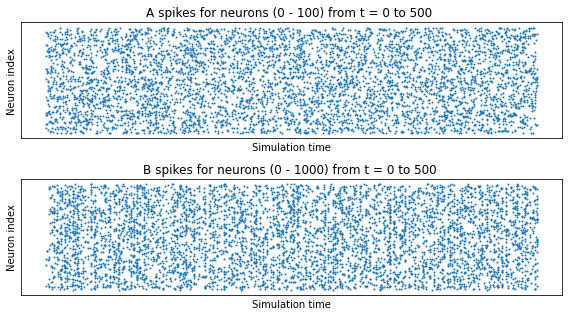

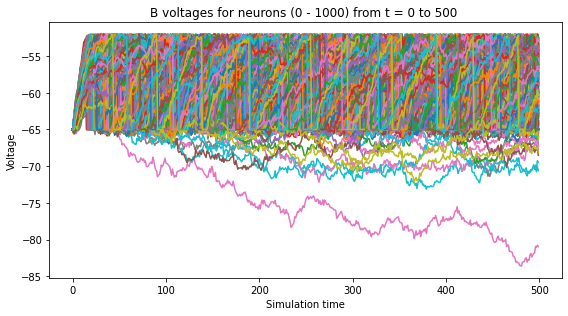

In [7]:
import torch
import matplotlib.pyplot as plt
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages

# Simulation time.
time = 500

# Create the network.
network = Network()

# Create and add input, output layers.
source_layer = Input(n=100)
target_layer = LIFNodes(n=1000)

network.add_layer(
    layer=source_layer, name="A"
)
network.add_layer(
    layer=target_layer, name="B"
)

# Create connection between input and output layers.
forward_connection = Connection(
    source=source_layer,
    target=target_layer,
    w=0.05 + 0.1 * torch.randn(source_layer.n, target_layer.n),  # Normal(0.05, 0.01) weights.
)

network.add_connection(
    connection=forward_connection, source="A", target="B"
)

# Create recurrent connection in output layer.
recurrent_connection = Connection(
    source=target_layer,
    target=target_layer,
    w=0.025 * (torch.eye(target_layer.n) - 1), # Small, inhibitory "competitive" weights.
)

network.add_connection(
    connection=recurrent_connection, source="B", target="B"
)

# Create and add input and output layer monitors.
source_monitor = Monitor(
    obj=source_layer,
    state_vars=("s",),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)
target_monitor = Monitor(
    obj=target_layer,
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)

network.add_monitor(monitor=source_monitor, name="A")
network.add_monitor(monitor=target_monitor, name="B")

# Create input spike data, where each spike is distributed according to Bernoulli(0.1).
input_data = torch.bernoulli(0.1 * torch.ones(time, source_layer.n)).byte()
inputs = {"A": input_data}

# Simulate network on input data.
network.run(inputs=inputs, time=time)

# Retrieve and plot simulation spike, voltage data from monitors.
spikes = {
    "A": source_monitor.get("s"), "B": target_monitor.get("s")
}
voltages = {"B": target_monitor.get("v")}

plt.ioff()
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
plt.show()